In [1]:
using Revise
using EnKF
using Distributions
using DocStringExtensions
using LinearAlgebra
using ProgressMeter
using DifferentialEquations

In [2]:
using Plots
default(tickfont = font("CMU Serif", 9), 
        titlefont = font("CMU Serif", 14), 
        guidefont = font("CMU Serif", 12),
        legendfont = font("CMU Serif", 10),
        grid = false)
# clibrary(:colorbrewer)
pyplot()

Plots.PyPlotBackend()

We are interested in simulating the Duffing oscillator with forcing
                $$\frac{d^2 x}{dt^2} = x - x^3 - \gamma \dot{x}   + d cos(\omega t)$$
with $\gamma = 0.1, d = 0.1$ and $\omega = 1.4$

Reference: http://physics.ucsc.edu/~peter/115/duffing.pdf

First, let us solve the dynamical equation using DifferentialEquations.jl with $x₀ = [1.0, -1.0]$ on  $[0.0, 50.0]$ with a RK4 method

We also define an `integrator` that will can propagate our solution from time t to t + Δt 

## Tools for the ensemble Kalman filter

The ensemble Kalman filter known under the sobriquet EnKF is a Monte-Carlo view of the Kalman filter suited for large and nonlinear systems introduced by Evensen, et al.(1999)

In [27]:
function duffing(du,u,p,t)
 du[1] = u[2]
 du[2] = u[1] - u[1]^3 -γ*u[2] + u[3]*cos(ω*t)
 du[3] = 0.0
end

γ = 0.1
d = 0.1
ω = 1.4

u0 = [1.0; -1.0; 0.1]
tspan = (0.0,50.0)

Δt = 1e-2
T = tspan[1]:Δt:tspan[end]

prob = ODEProblem(duffing, u0, tspan)
sol = solve(prob, RK4(), adaptive = false, dt = Δt)

integrator = init(prob, RK4(), adaptive =false, dt = Δt, save_everystep=false)

t: 0.0
u: 3-element Array{Float64,1}:
  1.0
 -1.0
  0.1

In [28]:
sol[1]

3-element Array{Float64,1}:
  1.0
 -1.0
  0.1

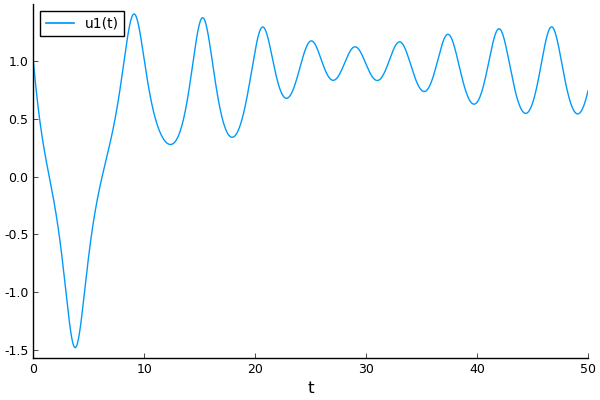

In [29]:
plot(sol, vars = (1))

In [30]:
function (::PropagationFunction)(t::Float64, ENS::EnsembleState{N, TS}) where {N, TS}
    for (i,s) in enumerate(ENS.S)
        
        set_t!(integrator, deepcopy(t))
        set_u!(integrator, deepcopy(s))
#         for j=1:10
        step!(integrator)
#         end
        ENS.S[i] = deepcopy(integrator.u)

    end
    
    return ENS
end

In [31]:
fprop = PropagationFunction()

PropagationFunction()

Define measurement function m

In [32]:
function (::MeasurementFunction)(t::Float64, s::TS) where TS
    return [s[2]]
end

In [33]:
function (::MeasurementFunction)(t::Float64) 
    return reshape([0.0, 1.0, 0.0],(1,3))
end

In [34]:
m = MeasurementFunction()

MeasurementFunction()

Define  real measurement function z

In [35]:
function (::RealMeasurementFunction)(t::Float64, ENS::EnsembleState{N, TZ}) where {N, TZ}
    let s = sol(t)
    fill!(ENS, [deepcopy(s[2])])
    end
    return ENS
end

In [36]:
z = RealMeasurementFunction()

RealMeasurementFunction()

Define covariance inflation

In [37]:
# A = MultiAdditiveInflation(2, 1.05, MvNormal(zeros(2), 2.0*I))
A = IdentityInflation()

IdentityInflation()

Define noise covariance

In [38]:
ϵ = AdditiveInflation(MvNormal(zeros(1), 1.0*I))

AdditiveInflation{1}(IsoNormal(
dim: 1
μ: [0.0]
Σ: [1.0]
)
)

In [39]:
N = 50
NZ = 1
isinflated = true
isfiltered = false
isaugmented = false

false

In [40]:
x₀ = [0.5, -0.5, 1.0]
ens = initialize(N, MvNormal(x₀, 2.0*I))
estimation_state = [deepcopy(ens.S)]

true_state = [deepcopy(x₀)]
covs = []

0-element Array{Any,1}

In [41]:
g = FilteringFunction()

FilteringFunction()

In [42]:
enkf = ENKF(N, NZ, fprop, A, g, m, z, ϵ, isinflated, isfiltered, isaugmented)

ENKF{50,1}(PropagationFunction(), IdentityInflation(), FilteringFunction(), MeasurementFunction(), RealMeasurementFunction(), AdditiveInflation{1}(IsoNormal(
dim: 1
μ: [0.0]
Σ: [1.0]
)
), true, false, false)

### Ensemble Kalman filter estimation

In [43]:
Δt = 1e-2
Tsub = 0.0:Δt:50.0-Δt

for (n,t) in enumerate(Tsub)

    global ens
    
    t, ens, cov = enkf(t, Δt, ens)
    
    push!(estimation_state, deepcopy(ens.S))
    push!(covs, deepcopy(cov))
    

end

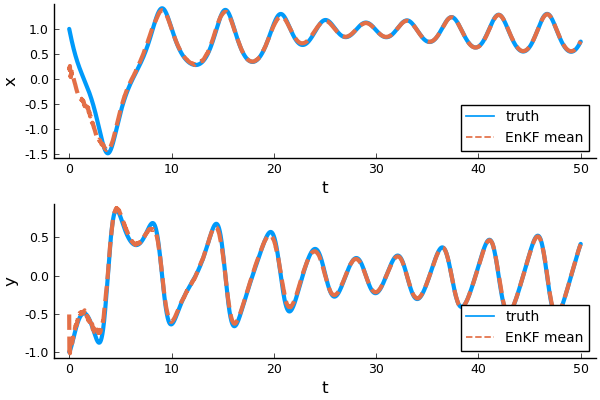

In [44]:
s =  hcat(sol(T).u...)
ŝ =  hcat(mean.(estimation_state)...)

plt = plot(layout = (2, 1), legend = :bottomright)
plot!(plt[1], T, s[1,1:end], linewidth = 3, label = "truth")
plot!(plt[1], Tsub, ŝ[1,1:end-1], linewidth = 3, markersize = 2, label = "EnKF mean", xlabel = "t", ylabel = "x", linestyle =:dash)

plot!(plt[2], T, s[2,1:end], linewidth = 3, label = "truth")
plot!(plt[2], Tsub, ŝ[2,1:end-1], linewidth = 3, markersize = 2, label = "EnKF mean", xlabel = "t", ylabel = "y", linestyle =:dash)

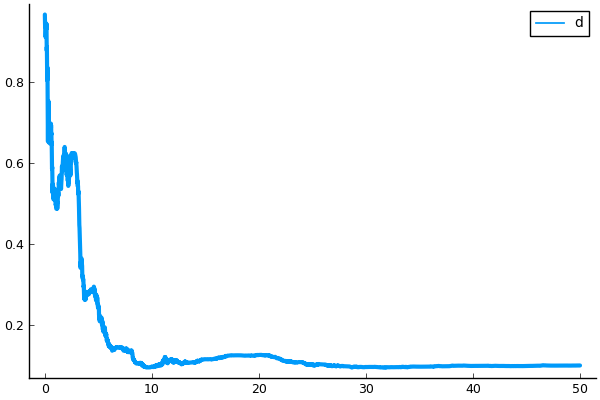

In [45]:
plot(Tsub, ŝ[3,1:end-1], linewidth = 3, label = "d", legend = true)

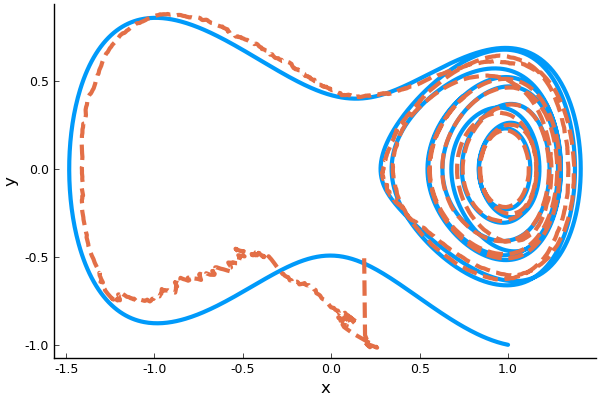

In [46]:
plot(s[1,:], s[2,:], linewidth = 3, label = "truth", legend = true)
plot!(ŝ[1,1:end-1], ŝ[2,1:end-1], linewidth = 3, label = "EnKF mean", xlabel = "x", 
    ylabel = "y", linestyle = :dash, legend = false)#:bottomleft)

Plot diagonal components of the *a posteriori* covariance

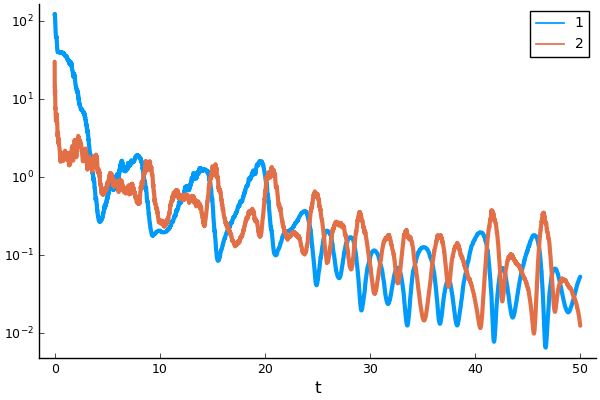

In [47]:
plot(Tsub, map(covs) do P  
        P[1,1]+ eps() end, yscale = :log10, linewidth = 3, label = "1")
plot!(Tsub, map(covs) do P
        P[2,2]+ eps() end, yscale = :log10, linewidth = 3, xlabel = "t", label = "2")

In [48]:
ŝ[3,1:end]

5001-element Array{Float64,1}:
 0.967316879804502  
 0.94717464966467   
 0.9411031189463094 
 0.9428466127876161 
 0.9367987254970128 
 0.9461518442442853 
 0.9371191571752442 
 0.9114574201462301 
 0.918408601282164  
 0.9323914413582574 
 0.9439831302294942 
 0.9438978401938969 
 0.9300772573168374 
 ⋮                  
 0.10113190468992798
 0.10111491072211465
 0.10112824474916154
 0.10113502127824743
 0.10111873542381102
 0.10114122777510155
 0.10115610217590339
 0.1011512054766945 
 0.1011678403847493 
 0.10117435962154558
 0.1011836895077096 
 0.10119840588380999